# BERT Model for Disaster Tweet Classification

In this Notebook, we will train a BERT model to classify tweets as disaster-related or not. We will use the preprocessed `train_data_mod.csv`, which contains the text and numerical features, to train the BERT model. <br>
We will be concatenating the `text` feature with `keyword_encoded`, `tweet_length` and `punctuation_count` as numerical values in the Neural Network Linear Layer.

- Note: Instead of using `BertForSequenceClassifier` and `Trainer` in the `transformers` library for training, we are going to implement our own Feed Foward Neural Network with the last hidden states of the BERT output to improve our model training speed. This also leaves us with customization for adding more hidden layers.

In [1]:
import torch
import numpy as np
import pandas as pd
import ast
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup, DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

In [2]:
# Load dataset
train = pd.read_csv('../preprocessing/train_data_mod.csv')
test = pd.read_csv('../preprocessing/test_data_mod.csv')

In [3]:
train_mod = train.copy()
test_mod = test.copy()

### Examine the Dataset
- We will use the raw text instead of the preprocessed text.
- Drop the columns that we are not using.
- Count the max length of tokens in text feature to ensure that the tokenizer max_length will not truncate off remaining text data.



In [4]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [5]:
train_mod.columns

Index(['id', 'keyword', 'location', 'text', 'target', 'preprocess_text',
       'bigram', 'trigram', 'pos', 'keyword_encoded', 'tweet_length',
       'punctuation_count'],
      dtype='object')

In [6]:
# drop unnecessary columns
drop_cols = ['keyword', 'location', 'preprocess_text','bigram','trigram', 'pos']


In [7]:
train_mod.drop(drop_cols, axis=1, inplace=True)
test_mod.drop(drop_cols, axis=1, inplace=True)

In [8]:
train_mod.columns

Index(['id', 'text', 'target', 'keyword_encoded', 'tweet_length',
       'punctuation_count'],
      dtype='object')

In [9]:
test_mod.columns

Index(['id', 'text', 'keyword_encoded', 'tweet_length', 'punctuation_count'], dtype='object')

In [10]:
numerical_features_columns = ['tweet_length', 'punctuation_count']

In [11]:
def max_length(text_column, tokenizer):
    max_len = 0
    for text in text_column:
        tokens = tokenizer.tokenize(text)
        # print(tokens)
        max_len = max(max_len, len(tokens))
    print("Max length: ", max_len, " tokens")
    return max_len

In [12]:
max_length(train_mod['text'], tokenizer)
max_length(test_mod['text'], tokenizer)

Max length:  104  tokens
Max length:  99  tokens


99

### Tokenizing the `Text` Feature
- Use BERT Tokenizer which will output input_ids and attention mask to be used in BERT model training.

In [13]:
encoded_inputs =  tokenizer(train_mod['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')


In [14]:
encoded_inputs_test = tokenizer(test_mod['text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')

In [15]:
encoded_inputs_test.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [16]:
input_ids = encoded_inputs['input_ids']
attention_mask = encoded_inputs['attention_mask']

In [17]:
input_ids_test = encoded_inputs_test['input_ids']
attention_mask_test = encoded_inputs_test['attention_mask']

In [18]:
print(input_ids)
print(input_ids.shape)
print(attention_mask)
print(attention_mask.shape)

tensor([[  101,  3458,  9115,  ...,     0,     0,     0],
        [  101,  4089,  1783,  ...,     0,     0,     0],
        [  101,  1398,  3159,  ...,     0,     0,     0],
        ...,
        [  101, 26528,   119,  ...,     0,     0,     0],
        [  101,  3284, 11950,  ...,     0,     0,     0],
        [  101,  1109,  6372,  ...,     0,     0,     0]])
torch.Size([7613, 106])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([7613, 106])


In [19]:
print(input_ids_test)
print(input_ids_test.shape)
print(attention_mask_test)
print(attention_mask_test.shape)

tensor([[  101,  2066,  2171,  ...,     0,     0,     0],
        [  101, 23599,  1164,  ...,     0,     0,     0],
        [  101,  1175,  1110,  ...,     0,     0,     0],
        ...,
        [  101,  2565,  2800,  ...,     0,     0,     0],
        [  101, 22157,  2349,  ...,     0,     0,     0],
        [  101,   108,  1392,  ...,     0,     0,     0]])
torch.Size([3263, 101])
tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
torch.Size([3263, 101])


### Standardize `tweet_length` and `punctuation_count`


In [20]:
from sklearn.preprocessing import StandardScaler

# Assuming you have a dataset df that contains both numerical and non-numerical features

# Separate the numerical and non-numerical features
numerical_features = train_mod[numerical_features_columns]
non_numerical_features = train_mod[['text','target']]

# Create an instance of the StandardScaler class
scaler = StandardScaler()

# Fit the scaler to the numerical features
scaler.fit(numerical_features)

# Transform the numerical features using the fitted scaler
numerical_features_scaled = scaler.transform(numerical_features)





In [21]:
numerical_features_scaled_test = scaler.transform(test_mod[numerical_features_columns])

In [22]:
# Convert scaled_numerical_features to a tensor
numerical_tensor = torch.tensor(numerical_features_scaled, dtype=torch.float32)

In [23]:
numerical_tensor_test = torch.tensor(numerical_features_scaled_test, dtype=torch.float32)

In [24]:
numerical_tensor

tensor([[-0.9501, -1.2671],
        [-1.8658, -1.2671],
        [ 0.9405, -0.8331],
        ...,
        [-1.0682,  0.9028],
        [ 1.0587, -0.3992],
        [-0.2116,  0.0348]])

In [25]:
numerical_tensor_test

tensor([[-1.9840, -1.4841],
        [-1.0978, -0.8331],
        [-0.1525, -1.0501],
        ...,
        [-1.3636, -0.3992],
        [-1.0682,  0.0348],
        [-0.9796, -0.8331]])

## Getting the hidden states from BERT
- The last hidden states correspond to the text embedding of each token in the text feature.
- We will only take the hidden state of [CLS] which is the starting token, as it contains the information for the entire tweet.
- The reason for doing this instead of directly training the model with BERTSequenceClassifier is because we also want to concatenate extra numerical inputs into our hidden layer.

In [29]:
import torch
from torch.utils.data import DataLoader, TensorDataset

batch_size = 512
dataset = TensorDataset(input_ids, attention_mask)
dataloader = DataLoader(dataset, batch_size=batch_size)


In [30]:
dataset_test = TensorDataset(input_ids_test, attention_mask_test)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size)

In [31]:
from transformers import BertModel

bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.eval()

text_embeddings = []

with torch.no_grad():
    for batch_input_ids, batch_attention_masks in dataloader:
        outputs = bert_model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        text_embeddings.append(batch_embeddings)

# Concatenate all batch embeddings into a single tensor
text_embeddings = torch.cat(text_embeddings, dim=0)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
bert_model = BertModel.from_pretrained('bert-base-cased')
bert_model.eval()
text_embeddings_test = []

with torch.no_grad():
    for batch_input_ids, batch_attention_masks in dataloader_test:
        outputs = bert_model(input_ids=batch_input_ids, attention_mask=batch_attention_masks)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        text_embeddings_test.append(batch_embeddings)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
# Concatenate all batch embeddings into a single tensor
text_embeddings_test = torch.cat(text_embeddings_test, dim=0)

In [34]:
combined_features_test = torch.cat([text_embeddings_test, numerical_tensor_test], dim=1)

In [35]:
combined_features = torch.cat([text_embeddings, numerical_tensor], dim=1)

In [36]:
combined_features.shape

torch.Size([7613, 770])

## Combined Neural Network class
- This is a simple feed foward neural network that concatenates the numerical features with the bert hidden states to be passed into a linear layer.
- More hidden layers can be added to generate a more complex Neural network

In [37]:
from torch import nn
from torch.optim import Adam
# Create a simple feed-forward neural network
class CombinedModel(nn.Module):
    def __init__(self, bert_output_size, num_numerical_features, num_classes):
        super(CombinedModel, self).__init__()
        self.layer = nn.Linear(bert_output_size + num_numerical_features, num_classes)
        

    def forward(self, x):
        return self.layer(x)





In [61]:
class CombinedModelMoreHLs(nn.Module):
    def __init__(self, bert_output_size, num_numerical_features, num_classes, hidden_size=128, dropout_rate=0.5):
        super(CombinedModelMoreHLs, self).__init__()
        
        self.layer1 = nn.Linear(bert_output_size + num_numerical_features, hidden_size)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.activation1 = nn.ReLU()

        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.activation2 = nn.ReLU()

        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.activation3 = nn.ReLU()

        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.dropout4 = nn.Dropout(dropout_rate)
        self.activation4 = nn.ReLU()

        self.output_layer = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.dropout1(x)
        x = self.activation1(x)

        x = self.layer2(x)
        x = self.dropout2(x)
        x = self.activation2(x)

        x = self.output_layer(x)
        return x

### Convert to `numpy` for training

In [39]:
combined_features = combined_features.numpy()

In [40]:
combined_features

array([[ 0.29352632, -0.0725253 , -0.15692264, ..., -0.10713238,
        -0.9500721 , -1.267124  ],
       [ 0.2558439 ,  0.18093783, -0.17079301, ..., -0.0249753 ,
        -1.8658271 , -1.267124  ],
       [ 0.05271018,  0.02512372,  0.10772833, ...,  0.07605556,
         0.94051886, -0.83313924],
       ...,
       [ 0.4800464 ,  0.09190952,  0.03730289, ...,  0.06442428,
        -1.068234  ,  0.90280026],
       [ 0.37591138,  0.06962702, -0.2249266 , ..., -0.06127468,
         1.0586808 , -0.39915434],
       [ 0.28238675,  0.10167535, -0.27841642, ...,  0.0055821 ,
        -0.21156   ,  0.03483052]], dtype=float32)

In [41]:
combined_features_test = combined_features_test.numpy()

In [42]:
labels = train_mod['target']

In [43]:
labels_numpy = labels.to_numpy()

### Declaration of Train and Validate function
- This uses cross fold validation with a total of 5 folds
- Note that due to time constraints, we are only going to cross validate 1 cycle over 5 folds.

In [44]:
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)


In [62]:
import torch.optim as optim
import torch.nn.functional as F

def train_and_validate(train_dataloader, val_dataloader, len_val_dataset, num_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu', lr=1e-3):
    # Replace with your custom model
    # model = CombinedModel(bert_output_size=768, num_numerical_features=len(numerical_features_columns), num_classes=1)
    model = CombinedModelMoreHLs(bert_output_size=768, num_numerical_features=len(numerical_features_columns), num_classes=1)
    model.to(device)

    print("Loaded Model to device")
    # Define the loss function and optimizer
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    print("Initialized Loss and Optimizer")
    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0.0
        for batch_features, batch_labels in train_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(batch_features)
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            total_loss += loss.item()

        # Print the average training loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}')

        # Validation loop
        model.eval()
        total_val_loss = 0.0
        correct_predictions = 0
        with torch.no_grad():
            for batch_features, batch_labels in val_dataloader:
                batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

                # Forward pass
                logits = model(batch_features)
                loss = loss_fn(logits, batch_labels)

                # Calculate the number of correct predictions
                predictions = (logits > 0).float()
                correct_predictions += (predictions == batch_labels).sum().item()

                total_val_loss += loss.item()

        # Print the average validation loss and accuracy for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {total_val_loss / len(val_dataloader)}, Validation Accuracy: {correct_predictions / len_val_dataset}')
    return correct_predictions / len_val_dataset

In [46]:
torch.tensor(combined_features[1])

tensor([ 2.5584e-01,  1.8094e-01, -1.7079e-01, -2.6513e-01, -4.3705e-01,
         5.8956e-02,  3.7884e-01,  1.1668e-01,  1.8814e-01, -1.3791e+00,
        -1.6295e-01,  3.5897e-01, -1.2012e-01, -1.8769e-01, -3.4638e-01,
         1.7986e-01,  6.7315e-02,  2.1108e-01,  2.7141e-01,  3.2946e-02,
        -4.3810e-02, -1.5269e-01,  5.6467e-01, -2.1989e-01,  3.0091e-01,
        -1.2909e-01,  1.6395e-01,  1.9878e-01, -1.8192e-01,  1.0246e-01,
         3.5770e-02,  2.9780e-02, -1.6495e-01,  2.9364e-01, -8.6084e-02,
         2.2865e-01, -1.2303e-01, -3.8921e-01,  3.9487e-02, -3.6750e-01,
        -3.9128e-01,  6.3324e-03,  3.2161e-01, -4.2472e-01,  3.1954e-03,
        -8.1638e-01,  4.3500e-02, -7.2592e-03, -2.6870e-01, -1.9641e-02,
        -7.7145e-02,  3.9884e-01,  5.6206e-01,  8.7265e-02,  3.3191e-01,
        -1.6589e-02,  1.7489e-02,  4.9950e-02, -4.0167e-01,  1.2930e-01,
         5.5091e-01,  6.6280e-03,  3.0802e-01, -9.7849e-02,  1.4942e-01,
        -1.5388e-02, -1.5098e-01,  4.6848e-01, -4.9

In [47]:
type(combined_features)

numpy.ndarray

In [48]:
type(labels)

pandas.core.series.Series

In [49]:
new_data = torch.tensor(labels_numpy).reshape(-1,1)

In [50]:
new_data.shape

torch.Size([7613, 1])

In [51]:
new_data.type()

'torch.LongTensor'

### Performed with CombinedModel
- Here we perform the cross validation and print the validation accuracy for each epoch
- Then the final average validation accuracy is printed after the cross validation completes.

In [52]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset))
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5347162181135081
Epoch 1/10, Validation Loss: 0.5010097459816808, Validation Accuracy: 0.767564018384767
Epoch 2/10, Training Loss: 0.47742430151995086
Epoch 2/10, Validation Loss: 0.4876218304740197, Validation Accuracy: 0.7806959947472094
Epoch 3/10, Training Loss: 0.4624437052668549
Epoch 3/10, Validation Loss: 0.4742159277824831, Validation Accuracy: 0.7820091923834537
Epoch 4/10, Training Loss: 0.4534211536659187
Epoch 4/10, Validation Loss: 0.47393152250357323, Validation Accuracy: 0.7931713722915299
Epoch 5/10, Training Loss: 0.4481302302262289
Epoch 5/10, Validation Loss: 0.4651305778488439, Validation Accuracy: 0.7925147734734077
Epoch 6/10, Training Loss: 0.44344139387562204
Epoch 6/10, Validation Loss: 0.46595514511094666, Validation Accuracy: 0.7925147734734077
Epoch 7/10, Training Loss: 0.4373610830545582
Epoch 7/10, Validation Loss: 0.4614184647408455, Validation Accuracy: 0.795141168745896

### Performed on CombinedModel but with different epoch sizes
- To roughly identify a more optimal epoch rate, we will loop through different epoch sizes, and do a scatter plot

In [53]:
epochs = [10, 20, 30, 40, 50, 60]
average_val_accuracy_dict = {}
for num_epoch in epochs:
    val_accuracies = []
    for train_idx, val_idx in skf.split(combined_features, labels):
        # Create TensorDatasets for the current fold
        train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

        # Create DataLoaders for the current fold
        train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

        # Train and validate your model for the current fold
        # Train and validate your model for the current fold and store the validation accuracy
        val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset), num_epoch)
        val_accuracies.append(val_accuracy)

    # Calculate the average validation accuracy across all folds
    average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
    average_val_accuracy_dict[num_epoch] = average_val_accuracy
    print(f'Average Validation Accuracy: {average_val_accuracy}')
    print(f'Number of Epochs: {num_epoch}')


Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/10, Training Loss: 0.5352119240039602
Epoch 1/10, Validation Loss: 0.49624163294649876, Validation Accuracy: 0.7741300065659882
Epoch 2/10, Training Loss: 0.47872721233705834
Epoch 2/10, Validation Loss: 0.4849823412938892, Validation Accuracy: 0.7826657912015759
Epoch 3/10, Training Loss: 0.4633874717874946
Epoch 3/10, Validation Loss: 0.4758645262159602, Validation Accuracy: 0.7852921864740644
Epoch 4/10, Training Loss: 0.45356030965571015
Epoch 4/10, Validation Loss: 0.5070801740853574, Validation Accuracy: 0.7747866053841103
Epoch 5/10, Training Loss: 0.45188547236224014
Epoch 5/10, Validation Loss: 0.49505341571819095, Validation Accuracy: 0.7767564018384767
Epoch 6/10, Training Loss: 0.4432294116773474
Epoch 6/10, Validation Loss: 0.4624300138800556, Validation Accuracy: 0.7918581746552856
Epoch 7/10, Training Loss: 0.4396355959960795
Epoch 7/10, Validation Loss: 0.46107327544096255, Validation Accuracy: 0.795797767564

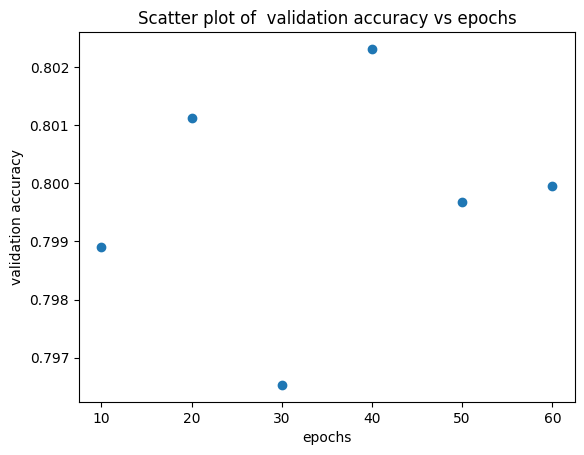

In [54]:
# Using the average_val_accuracy_dict dictionary, plot a graph with number of epochs on x-axis and average validation accuracy on y-axis
import matplotlib.pyplot as plt

# Get the keys and values as separate lists
keys = list(average_val_accuracy_dict.keys())
values = list(average_val_accuracy_dict.values())

# Create a scatter plot
plt.scatter(keys, values)

# Add labels and a title
plt.xlabel('epochs')
plt.ylabel('validation accuracy')
plt.title('Scatter plot of  validation accuracy vs epochs')

# Display the plot
plt.show()


Based on this graph, we can see that `epoch = 40` is the optimal parameter as it will give us a higher validation accuracy.

#### Performed with CombinedModelMoreHLs 2 layers
- With the optimal epoch size, we can also explore if having more hidden layers will help with the final average validation accuracy

In [56]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset), num_epochs=40)
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/40, Training Loss: 0.5560178285625976
Epoch 1/40, Validation Loss: 0.4858637933487667, Validation Accuracy: 0.7728168089297439
Epoch 2/40, Training Loss: 0.503550732386081
Epoch 2/40, Validation Loss: 0.4899200462389991, Validation Accuracy: 0.7649376231122784
Epoch 3/40, Training Loss: 0.48799195924768923
Epoch 3/40, Validation Loss: 0.46860000268795104, Validation Accuracy: 0.7793827971109653
Epoch 4/40, Training Loss: 0.47601003148971893
Epoch 4/40, Validation Loss: 0.4595032822711305, Validation Accuracy: 0.7931713722915299
Epoch 5/40, Training Loss: 0.4778352170263532
Epoch 5/40, Validation Loss: 0.4828306177133665, Validation Accuracy: 0.7754432042022325
Epoch 6/40, Training Loss: 0.4717351252169121
Epoch 6/40, Validation Loss: 0.4849641940590599, Validation Accuracy: 0.7708470124753776
Epoch 7/40, Training Loss: 0.4613897866249241
Epoch 7/40, Validation Loss: 0.45244472325628343, Validation Accuracy: 0.796454366382140

Average Validation Accuracy: 0.8000782569156423

In [57]:
average_val_accuracy_dict = {}
average_val_accuracy_dict[2] = 0.8000782569156423

#### Performed with CombinedModelMoreHLs 3 layers

In [60]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset), num_epochs=40)
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')
average_val_accuracy_dict[3] = average_val_accuracy

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/40, Training Loss: 0.6747242410977682
Epoch 1/40, Validation Loss: 0.6398675739765167, Validation Accuracy: 0.6270518713066316
Epoch 2/40, Training Loss: 0.6265063484509786
Epoch 2/40, Validation Loss: 0.591761976480484, Validation Accuracy: 0.7261982928430729
Epoch 3/40, Training Loss: 0.5925513009230295
Epoch 3/40, Validation Loss: 0.5596535801887512, Validation Accuracy: 0.737360472751149
Epoch 4/40, Training Loss: 0.5590356687704722
Epoch 4/40, Validation Loss: 0.5219336152076721, Validation Accuracy: 0.7649376231122784
Epoch 5/40, Training Loss: 0.5308896203835806
Epoch 5/40, Validation Loss: 0.49757087230682373, Validation Accuracy: 0.7767564018384767
Epoch 6/40, Training Loss: 0.5075901250044504
Epoch 6/40, Validation Loss: 0.48568572103977203, Validation Accuracy: 0.778069599474721
Epoch 7/40, Training Loss: 0.4919910728931427
Epoch 7/40, Validation Loss: 0.47702476382255554, Validation Accuracy: 0.7800393959290873
E

#### Performed with CombinedModelMoreHLs 4 layers

In [63]:
val_accuracies = []
for train_idx, val_idx in skf.split(combined_features, labels):
    # Create TensorDatasets for the current fold
    train_dataset = TensorDataset(torch.tensor(combined_features[train_idx]), torch.tensor(labels_numpy[train_idx].reshape(-1,1), dtype=torch.float32))
    val_dataset = TensorDataset(torch.tensor(combined_features[val_idx]), torch.tensor(labels_numpy[val_idx].reshape(-1,1), dtype=torch.float32))

    # Create DataLoaders for the current fold
    train_dataloader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=1024, shuffle=False)

    # Train and validate your model for the current fold
    # Train and validate your model for the current fold and store the validation accuracy
    val_accuracy = train_and_validate(train_dataloader, val_dataloader, len(val_dataset), num_epochs=40)
    val_accuracies.append(val_accuracy)

# Calculate the average validation accuracy across all folds
average_val_accuracy = sum(val_accuracies) / len(val_accuracies)
print(f'Average Validation Accuracy: {average_val_accuracy}')
average_val_accuracy_dict[4] = average_val_accuracy

Loaded Model to device
Initialized Loss and Optimizer
Epoch 1/40, Training Loss: 0.6704482734203339
Epoch 1/40, Validation Loss: 0.6340758204460144, Validation Accuracy: 0.711096520026264
Epoch 2/40, Training Loss: 0.6225814819335938
Epoch 2/40, Validation Loss: 0.5856404304504395, Validation Accuracy: 0.7104399212081418
Epoch 3/40, Training Loss: 0.5904293358325958
Epoch 3/40, Validation Loss: 0.5507956147193909, Validation Accuracy: 0.7301378857518056
Epoch 4/40, Training Loss: 0.5495012303193411
Epoch 4/40, Validation Loss: 0.5164992213249207, Validation Accuracy: 0.7701904136572554
Epoch 5/40, Training Loss: 0.5278213024139404
Epoch 5/40, Validation Loss: 0.4998415857553482, Validation Accuracy: 0.7728168089297439
Epoch 6/40, Training Loss: 0.5025688608487447
Epoch 6/40, Validation Loss: 0.49279969930648804, Validation Accuracy: 0.7728168089297439
Epoch 7/40, Training Loss: 0.49094679951667786
Epoch 7/40, Validation Loss: 0.4806216359138489, Validation Accuracy: 0.7813525935653316


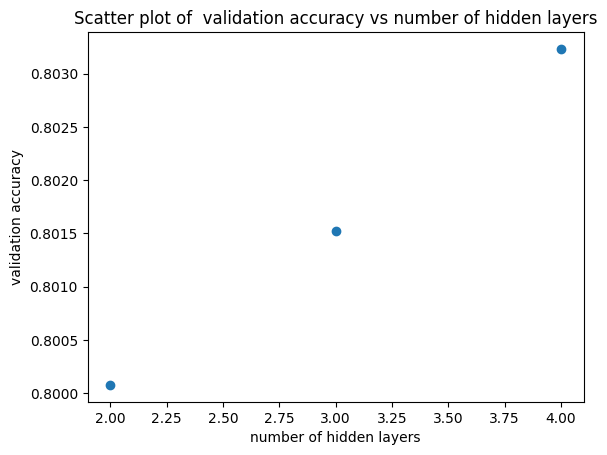

In [64]:
# Get the keys and values as separate lists
keys = list(average_val_accuracy_dict.keys())
values = list(average_val_accuracy_dict.values())

# Create a scatter plot
plt.scatter(keys, values)

# Add labels and a title
plt.xlabel('number of hidden layers')
plt.ylabel('validation accuracy')
plt.title('Scatter plot of  validation accuracy vs number of hidden layers')

# Display the plot
plt.show()


Adding more Hidden layers did not seem to significantly affect the validation accuracy, as seen from the scatter plot the accuracy growth is at around `0.0015`. We will use the original CombinedModel for our training.

### Final Training of CombinedModel with Full Dataset

In [71]:
num_epochs = 40
# Create a TensorDataset for the entire dataset
full_dataset = TensorDataset(torch.tensor(combined_features), torch.tensor(labels_numpy.reshape(-1,1), dtype=torch.float32))

# Create a DataLoader for the entire dataset
full_dataloader = DataLoader(full_dataset, batch_size=8, shuffle=True)

# Train your model on the entire dataset (You can remove the validation loop from your train_and_validate function)
def train_full(train_dataloader, num_epochs=num_epochs, device='cuda' if torch.cuda.is_available() else 'cpu', lr=1e-3):
    # Replace with your custom model
    model = CombinedModel(bert_output_size=768, num_numerical_features=len(numerical_features_columns), num_classes=1)
    model.to(device)

    # Define the loss function and optimizer
    loss_fn = torch.nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        # Training loop
        model.train()
        total_loss = 0.0
        for batch_features, batch_labels in train_dataloader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            logits = model(batch_features)
            loss = loss_fn(logits, batch_labels)

            # Backward pass
            loss.backward()

            # Update the model parameters
            optimizer.step()

            total_loss += loss.item()

        # Print the average training loss for the epoch
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {total_loss / len(train_dataloader)}')
    return model

# Train the model on the entire dataset
optimized_model = train_full(full_dataloader)


Epoch 1/40, Training Loss: 0.5317186078823665
Epoch 2/40, Training Loss: 0.4762610930855535
Epoch 3/40, Training Loss: 0.4608021482762669
Epoch 4/40, Training Loss: 0.45401756140646066
Epoch 5/40, Training Loss: 0.4466279201099978
Epoch 6/40, Training Loss: 0.4435521515806307
Epoch 7/40, Training Loss: 0.4389368411419647
Epoch 8/40, Training Loss: 0.43844563233032197
Epoch 9/40, Training Loss: 0.43577248254055234
Epoch 10/40, Training Loss: 0.4317254404999128
Epoch 11/40, Training Loss: 0.4298154602234228
Epoch 12/40, Training Loss: 0.4300938271369566
Epoch 13/40, Training Loss: 0.42776172357697445
Epoch 14/40, Training Loss: 0.42666732605562363
Epoch 15/40, Training Loss: 0.424092243781642
Epoch 16/40, Training Loss: 0.4219192631519204
Epoch 17/40, Training Loss: 0.4209210357370497
Epoch 18/40, Training Loss: 0.42109948521119955
Epoch 19/40, Training Loss: 0.41835703973525334
Epoch 20/40, Training Loss: 0.4179773399715914
Epoch 21/40, Training Loss: 0.4196624837800109
Epoch 22/40, Tra

## Apply on Test Dataset

In [72]:
# Assuming your test data is a numpy array
test_combined_features = combined_features_test
test_combined_features_tensor = torch.tensor(combined_features_test, dtype=torch.float32)
optimized_model.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Move the model and test features to the appropriate device
optimized_model.to(device)
test_combined_features_tensor = test_combined_features_tensor.to(device)

# Perform a forward pass through the model to obtain predictions
with torch.no_grad():
    logits = optimized_model(test_combined_features_tensor)

# Process the predictions to get the final predicted targets
# If it's a binary classification problem, you can apply a threshold and convert the output to binary labels (0 or 1)
threshold = 0
predicted_targets = (logits > threshold).float().cpu().numpy()

# If it's a multi-class problem, you can apply a softmax function and get the class with the highest probability
# predicted_targets = torch.argmax(torch.softmax(logits, dim=1), dim=1).cpu().numpy()

print(predicted_targets)


[[1.]
 [1.]
 [0.]
 ...
 [1.]
 [1.]
 [0.]]


In [73]:
predicted_targets = predicted_targets.astype(int)
df = pd.DataFrame(predicted_targets, columns=['target'])
df = pd.concat([ test['id'],df], axis=1)

In [74]:
df.head()

,id,target
0,0,1
1,2,1
2,3,0
3,9,1
4,11,1


In [75]:
df.to_csv('BERT_predictions/BERT_CombinedNN.csv', index=False)

## Conclusion
This approach of taking numerical inputs through a linear layer in the Neural Network resulted in an accuracy of `0.808` based on my kaggle submission. This performed `4-6%` better than the Traditional models. This is quite interesting since `BERT_CC.ipynb` performed significantly worse using a similar approach. This could mean that keeping the numerical inputs as separate features and then passing into the Neural Network is a better approach than concatenating into a single string.